# MCMC for dummies
(взято из: https://habr.com/ru/company/wunderfund/blog/279545/)  

Monte-Carlo Markov Chain алгоритм позволяет получить апостериорное распределение некоего параметра, влияющего на модель, при условии наличия наблюдений из этой модели.
В качестве примера возьмем модель нормального распределения с средним = 0 и дисперсией = 1. Предположим, что дисперсию мы знаем, а среднее значение - нет, оно и является неизвестным параметром системы, распределение которого необходимо оценить.

In [1]:
# импортируем все нужное
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, beta

sns.set_style('white')
sns.set_context('talk')

np.random.seed(112)

Теперь сгенерируем данные - это будут 20 точек, нормально распределённых вокруг нуля.

In [2]:
data = np.random.randn(20)

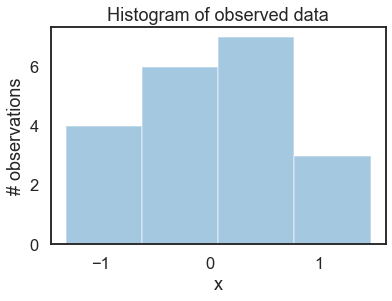

In [3]:
# визуализация
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Для такой простой задачи есть аналитическое решение. Вычислим его для того, чтобы потом проверить корректность MCMC.

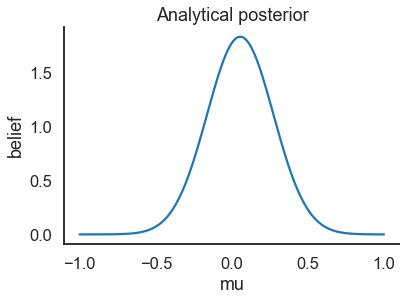

In [4]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

Далее укажем известный нам параметр - дисперсию распределения, а также изначальную оценку неизвестного параметра mu.

In [5]:
VAR = 1
mu_current = -1.3

Функция ниже представлена для визуализации хода работы алгоритма и честно сперта из источника.

In [6]:
# Длинная и страшная функция визуализации
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Визуализация априорного распределения вероятностей
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Правдоподобие
    likelihood_current = norm(mu_current, VAR).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, VAR).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Апостериорное распределение вероятностей
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()

MCMC алгоритм работает следующим образом: на каждом шаге имеется изначальное значение неизвестного параметра, а затем предлагается переместиться в "новое место", в некую другую оценку этого же параметра. 

Самый простой вариант, алгоритм Метрополиса, который здесь и будет реализован, предполагает, что неизвестный параметр распределен нормально с центром в текущей точке и некоей дисперсией (данное распределение, центр и дисперсия не имеют ничего общего с данными, это оценка распределения самого параметра). Из этого распределения выбирается случайная точка - новое предлагаемое значение параметра. После выбора предлагаемого значения считается функция правдоподобия для старого значения и для нового значения (насколько хорошо существующие данные описываются старым параметром и новым параметром).

После вычисления функций правдоподобия они умножаются на априорные вероятности каждого из параметров (текущего и предлагаемого) - получаем числитель из формулы Байеса. А затем данные значения делятся друг на друга (предлагаемый на текущий) - таким образом мы избавляемся от знаменателя из формулы Байеса, подсчет которого сопряжен с огромными вычислительными мощностями.

Результат данного деления можно описать примерно следующим образом: для предлагаемого значения параметра считается априорная вероятность его получить из распределения текущего параметра. Данная вероятность будет по определению меньше аналогичной вероятности для текущего параметра (просто потому что эта вероятность для текущего значения параметра есть максимум его функции pdf нормального распределения). Однако значение правдоподобия для предлагаемого параметра может быть выше, показывая, что он лучше описывает данные. Если априорная вероятность получения предлагаемого параметра в два раза меньше, чем текущего, то при значении функции правдоподобия в два раза и более мы получим результат деления больше единицы. Для того, чтобы получить апостериорное распределение (а не просто восхождение к максимуму) мы можем в качестве вероятности перехода принять именно этот результат деления p_accept (формально min(p_accept, 1)) - тогда при сильных улучшениях алгоритм будет гарантированно принимать новое значение, каким бы невероятным оно не было, однако при менее сильных улучшениях вероятность перехода меньше 1 (более того, она больше 0 (и меньше 1) даже при ухудшениях значения правдоподобия), что и даст нам апостериорное распределение.

Напишем функцию-семплер, которая выполняет получение N семплов с указанным изначальным значением параметра mu_init, шириной интервала для "прыжков" proposal_width, а также априорным распределением неизвестного параметра - mu_prior_mu и mu_prior_sd.

In [7]:
# предположим априорное распределение ~ N(1, 2)
def sampler(data, samples=4, mu_init=.7, proposal_width=.5, plot=False, mu_prior_mu=1, mu_prior_sd=2.):
    mu_current = mu_init
    posterior = [mu_current]  # храним "след" алгоритма, т.е. свершившиеся переходы - это и будем потом анализировать
    for i in range(samples):
        # предлагаем новую позицию
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Вычисляем правдоподобие, перемножая вероятности для каждой точки данных
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Вычисляем априорное распределение вероятностей для текущего и предлагаемого mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Принять предложенную точку?
        p_accept = p_proposal / p_current
        
        # Обычно сюда было бы включено априорное распределение вероятностей, здесь это опущено для простоты 
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Обновляем позицию
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

Посмотрим на несколько последовательных шагов алгоритма. 

В первом столбце показано априорное распределение вероятностей, то есть – наши предположения о μ до ознакомления с данными. Как можно видеть, это распределение не меняется, мы лишь показываем здесь предложения нового значения μ. Вертикальные синие линии – это текущее μ. А предлагаемое μ отображается либо зелёным, либо красным цветом (это, соответственно, принятые и отвергнутые предложения).

Во втором столбце – функция правдоподобия и то, что мы используем для того, чтобы оценить, насколько хорошо модель объясняет данные. Здесь можно заметить, что график меняется в соответствии с предлагаемым μ. Там же отображается и синяя гистограмма – сами данные. Сплошная линия выводится либо зелёным, либо красным цветом – это график функции правдоподобия при mu, предложенном на текущем шаге. Чисто интуитивно понятно, что чем сильнее функция правдоподобия перекрывается с графическим отображением данных – тем лучше модель объясняет данные и тем выше будет результирующая вероятность. Точечная линия того же цвета – это предложенное mu, точечная синяя линия – это текущее mu.

В третьей колонке – апостериорное распределение вероятностей. Здесь показано нормализованное апостериорное распределение, но, как мы выяснили выше, можно просто умножить предыдущее значение для текущего и предложенного μ на значение функции правдоподобия для двух μ для того, чтобы получить ненормализованные значения апостериорного распределения (что мы и используем для реальных вычислений), и разделить одно на другое для того, чтобы получить вероятность принятия предложенного значения.

В четвёртой колонке представлен след выборки, то есть – значения μ, сэмплы, полученные на основе модели. Здесь мы показываем каждый сэмпл, вне зависимости от того, был ли он принят или отвергнут (в таком случае линия не меняется).

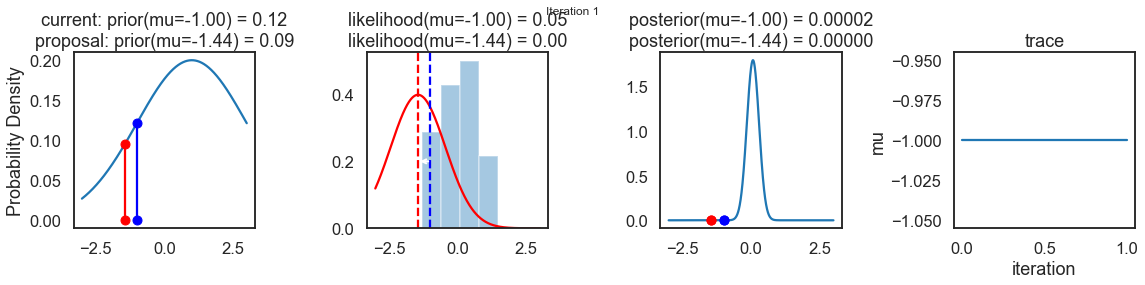

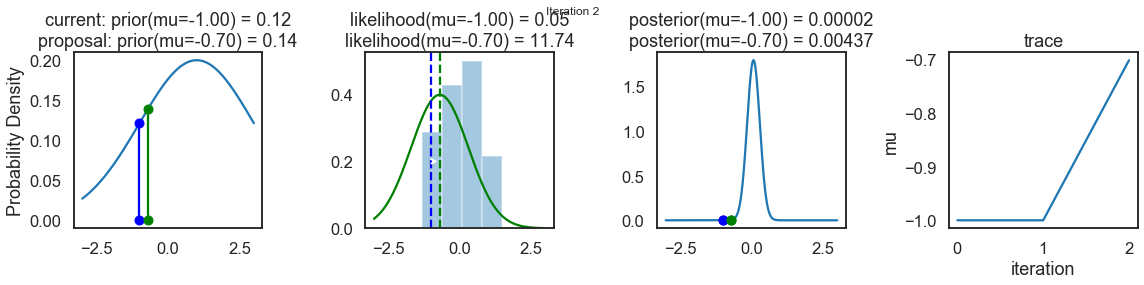

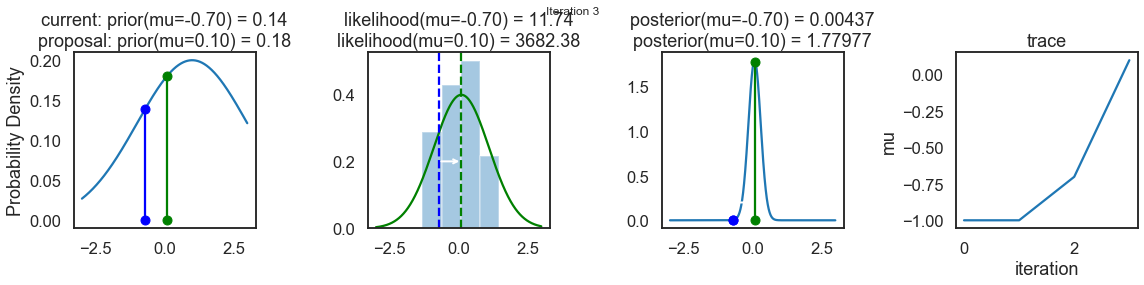

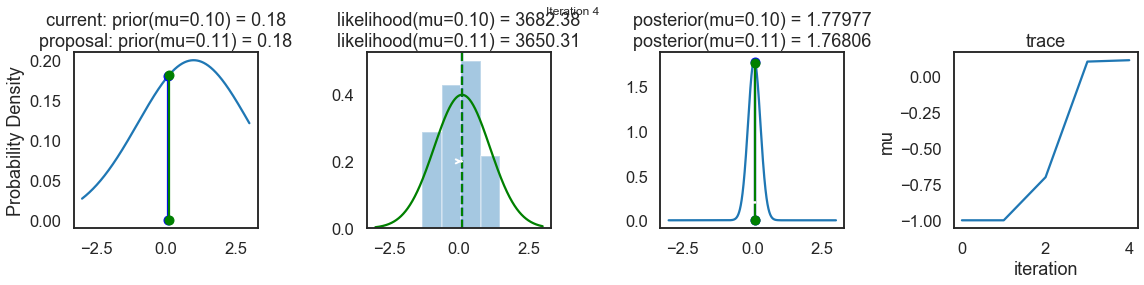

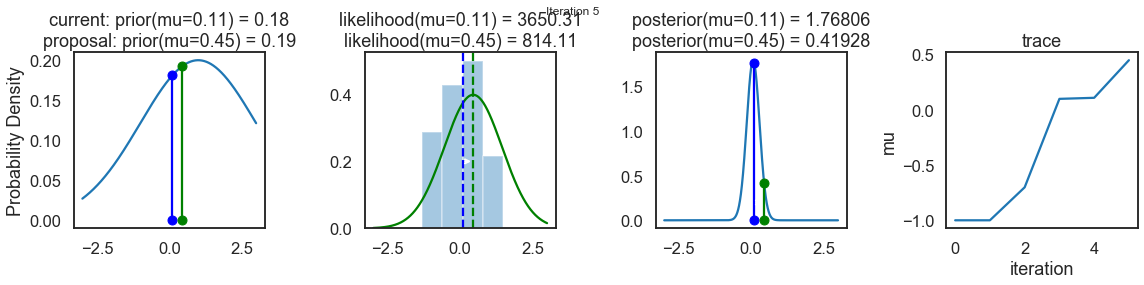

In [8]:
sampler(data, samples=5, mu_init=-1., plot=True);

Каждый принятый переход добавляется в след - причем статистически переходы в "правильное" значение (или около него) будут происходить чаще, давая нам корректное апостериорное распределение.

Проверим. Посчитаем 15000 шагов алгоритма и визуализируем "блуждание" параметра.

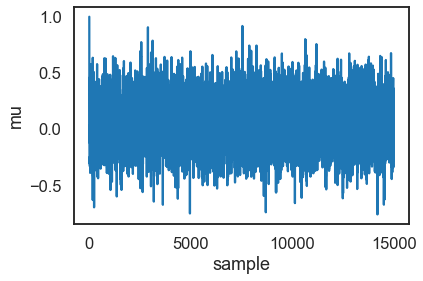

In [9]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

И построим распределение параметра mu, сравнив его заодно с аналитически (еще в начале) вычисленным.

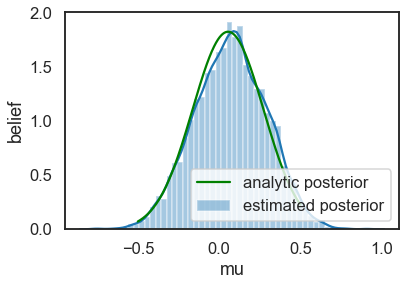

In [10]:
ax = plt.subplot()
sns.distplot(posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

Как можно заметить, распределение практически полностью совпадает с аналитическим, даже несмотря на некорректный выбор априорного распределения (хотя при меньшем числе шагов оно влияло бы гораздо сильнее).

## MCMC for not so dummies
А теперь используем MCMC для выяснения всех параметров бета распределения, которые зададим случайным образом.

In [11]:
# получаем случайные значения параметров для бета распределения (они обязательно положительны)
dist = sp.stats.uniform(0, 10)
beta_a, beta_b = dist.rvs(), dist.rvs()
print(beta_a, beta_b)

4.743826907818346 2.153087047687351


In [12]:
beta_dist = sp.stats.beta(beta_a, beta_b)
data = beta_dist.rvs(size=200)

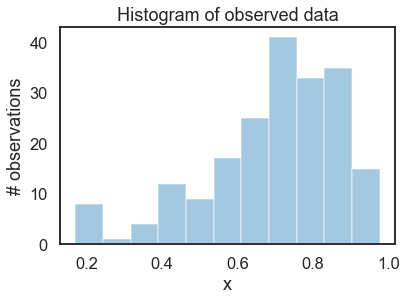

In [13]:
ax = plt.subplot()
sns.distplot(data, kde=False, ax=ax)
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

Далее напишем версию семплера для двух переменных (a и b):

In [14]:
# мы знаем, что параметры мы брали из стандартного нормального распределения, умножали на 10 и брали модуль
# для простоты возьмем априорное распределение каждого параметра ~ N(5, 5)
def sampler(
    data,
    samples=10,
    a_init=2.0,
    b_init=2.0,
    proposal_width=1.,
    a_prior_mu=5.,
    a_prior_std=5.,
    b_prior_mu=5.,
    b_prior_std=5.
):
    
    a_current, b_current = a_init, b_init
    a_posterior, b_posterior = np.zeros(samples), np.zeros(samples)
    
    for i in range(samples):
        # A
        a_proposal = norm(a_current, proposal_width).rvs()
        
        likelihood_current = beta(a_current, b_current).pdf(data).prod()
        likelihood_proposal = beta(a_proposal, b_current).pdf(data).prod()
        
        a_prior_current = norm(a_prior_mu, a_prior_std).pdf(a_current)
        a_prior_proposal = norm(a_prior_mu, a_prior_std).pdf(a_proposal)
        
        p_current = likelihood_current * a_prior_current
        p_proposal = likelihood_proposal * a_prior_proposal
        
        p_accept = p_proposal / p_current
        accept = np.random.rand() < p_accept
        if accept: a_current = a_proposal
        
        # B
        b_proposal = norm(b_current, proposal_width).rvs()
        
        likelihood_current = beta(a_current, b_current).pdf(data).prod()
        likelihood_proposal = beta(a_current, b_proposal).pdf(data).prod()
        
        b_prior_current = norm(b_prior_mu, b_prior_std).pdf(b_current)
        b_prior_proposal = norm(b_prior_mu, b_prior_std).pdf(b_proposal)
        
        p_current = likelihood_current * b_prior_current
        p_proposal = likelihood_proposal * b_prior_proposal
        
        p_accept = p_proposal / p_current
        accept = np.random.rand() < p_accept
        if accept: b_current = b_proposal
        
        a_posterior[i] = a_current
        b_posterior[i] = b_current
        
    return a_posterior, b_posterior

In [15]:
# запускаем процесс
a_posterior, b_posterior = sampler(data, samples=40000)

True values: a=4.743826907818346, b=2.153087047687351


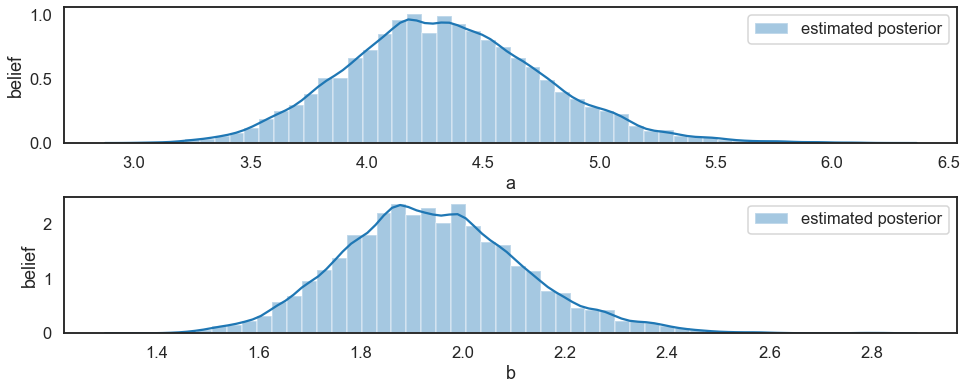

In [16]:
fig = plt.figure(figsize=(16, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(211)
bx = fig.add_subplot(212)

sns.distplot(a_posterior[500:], ax=ax, label='estimated posterior')
x = np.linspace(0, 10, 500)
_ = ax.set(xlabel='a', ylabel='belief');
ax.legend();

sns.distplot(b_posterior[500:], ax=bx, label='estimated posterior')
x = np.linspace(0, 10, 500)
_ = bx.set(xlabel='b', ylabel='belief');
bx.legend();

print(f"True values: a={beta_a}, b={beta_b}")